In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pyspark.ml.feature import PCA, VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors

In [ ]:
#  **Initialize Spark Session with High Memory Limits**
spark = SparkSession.builder.config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").config("spark.driver.maxResultSize", "4g").getOrCreate()

#  **Read Large CSV into PySpark DataFrame (No Memory Crash)**
file_path = "/content/drive/MyDrive/wind_farm_c_combined_joined_eventids.csv/part-00000-eb996602-9673-4787-b369-24e70221baee-c000.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
df.show()

+--------+-------------------+--------+---+----------+--------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+-----------+-----------+------------------+------------------+-----------+-----------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---

In [ ]:
# **Create Label Column**
df = df.withColumn("label", when(df["event_label"] == "normal", 1).otherwise(0))

In [ ]:
#  **Train-Test Split (PySpark)**
train_df = df.filter(df["train_test"] == "train")
test_df = df.filter(df["train_test"] == "prediction")

In [ ]:
print(f"Train Data Count: {train_df.count()}, Test Data Count: {test_df.count()}")

Train Data Count: 838656, Test Data Count: 42156


# PCA DENEME

In [ ]:
# Handle Missing Values
train_df = train_df.na.drop()  # Drop rows with missing values
test_df = test_df.na.drop()

In [ ]:
train_df.show()

+--------+-------------------+--------+---+----------+--------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+-----------+-----------+------------------+------------------+-----------+-----------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---

In [ ]:
#  Select Numeric Features for PCA
# Replace `numeric_cols` with the actual column names of your numeric features
numeric_cols = [col for col in train_df.columns if col not in ['event_id',
                                                               'time_stamp',
                                                               'asset_id',
                                                               'id',
                                                               'train_test',
                                                               'status_type_id',
                                                               'event_label',
                                                               'event_description',
                                                               'label']]  # Exclude non-numeric columns

X_train = train_df.select(numeric_cols)
y_train = train_df.select("label").collect()
X_test = test_df.select(numeric_cols)
y_test = test_df.select("label").collect()

In [ ]:
#  Assemble Features into a Vector Column
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
X_train = assembler.transform(X_train)
X_test = assembler.transform(X_test)

#  Scale the Data (Standardization)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(X_train)
X_train = scaler_model.transform(X_train)
X_test = scaler_model.transform(X_test)

#  Apply PCA
k = 25 # Number of principal components (adjust based on explained variance)
pca = PCA(k=k, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(X_train)

#  Transform the Data
train_pca = pca_model.transform(X_train)
test_pca = pca_model.transform(X_test)

# View the Results
print("Explained Variance:", pca_model.explainedVariance)
train_pca.select("pca_features").show(5, truncate=False)
test_pca.select("pca_features").show(5, truncate=False)

Explained Variance: [0.21983029246261385,0.08073504908321683,0.05152042457171483,0.04535126399697504,0.039656935710554723,0.032480931375953835,0.028303005080059927,0.027381257182696968,0.022269152131896633,0.017401337058558793,0.0161318373775283,0.014918993407737682,0.012822566318752608,0.01264631699268907,0.01187092964526076,0.01121500413476669,0.010583294512859057,0.010572554580966903,0.010071996039644815,0.009622561730270913,0.009358037964290696,0.009125239932198987,0.007861284419271669,0.007283685018411834,0.007136198478983372]
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
sum(pca_model.explainedVariance)

0.7261501492078749

In [ ]:
train_pca.show()

+------------+------------+------------+------------+------------+------------+------------+------------+------------------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+-----------+-----------+------------------+------------------+-----------+-----------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------------+------------+-----------

In [ ]:
train_df.show()

+--------+-------------------+--------+---+----------+--------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+-----------+-----------+------------------+------------------+-----------+-----------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# Add a unique identifier to train_pca
train_pca = train_pca.withColumn("row_id", monotonically_increasing_id())

# Add a unique identifier to train_df
train_df = train_df.withColumn("row_id", monotonically_increasing_id())

# Join train_pca with train_df to add the time_stamp and event_label columns
train_pca_with_labels = train_pca.join(
    train_df.select("row_id", "time_stamp", "event_label"),
    on="row_id",
    how="inner"
)

# Drop the row_id column if no longer needed
train_pca_with_labels = train_pca_with_labels.drop("row_id")

# Select the desired columns
final_train_df = train_pca_with_labels.select("time_stamp", "pca_features", "event_label")

# Show the resulting DataFrame
final_train_df.show()

+-------------------+--------------------+-----------+
|         time_stamp|        pca_features|event_label|
+-------------------+--------------------+-----------+
|2018-11-03 04:20:00|[-2.2031636024545...|     normal|
|2018-11-03 05:20:00|[0.58412846015500...|     normal|
|2018-11-03 05:30:00|[-0.9388318774831...|     normal|
|2018-11-03 05:50:00|[-0.7261565338730...|     normal|
|2018-11-03 07:10:00|[2.22636715149840...|     normal|
|2018-11-03 07:30:00|[1.60810421280990...|     normal|
|2018-11-03 08:00:00|[1.73963583519323...|     normal|
|2018-11-03 08:30:00|[2.60664583063113...|     normal|
|2018-11-03 08:40:00|[1.79510357755570...|     normal|
|2018-11-03 08:50:00|[2.17555932725401...|     normal|
|2018-11-03 09:00:00|[2.72803711986692...|     normal|
|2018-11-03 09:10:00|[2.26959454120023...|     normal|
|2018-11-03 09:30:00|[2.80161402243774...|     normal|
|2018-11-03 09:40:00|[3.13727304295201...|     normal|
|2018-11-03 09:50:00|[2.61132668792981...|     normal|
|2018-11-0

In [ ]:
test_pca.show()

+------------+------------+------------+------------+------------+------------+------------+------------+------------------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------------+-----------+-----------+------------------+------------------+-----------+-----------+------------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------------+------------+-----------

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# Add a unique identifier to test_pca
test_pca = test_pca.withColumn("row_id", monotonically_increasing_id())

# Add a unique identifier to test_df
test_df = test_df.withColumn("row_id", monotonically_increasing_id())

# Join test_pca with test_df to add the time_stamp and event_label columns
test_pca_with_labels = test_pca.join(
    test_df.select("row_id", "time_stamp", "event_label"),
    on="row_id",
    how="inner"
)

# Drop the row_id column if no longer needed
test_pca_with_labels = test_pca_with_labels.drop("row_id")

# Select the desired columns
final_test_df = test_pca_with_labels.select("time_stamp", "pca_features", "event_label")

# Show the resulting DataFrame
final_test_df.show()

+-------------------+--------------------+-----------+
|         time_stamp|        pca_features|event_label|
+-------------------+--------------------+-----------+
|2019-11-05 06:50:00|[-9.2983516414045...|     normal|
|2019-11-07 09:00:00|[-6.5850755767311...|     normal|
|2019-11-10 04:30:00|[-4.4783705272415...|     normal|
|2019-11-11 05:30:00|[-13.173415505440...|     normal|
|2019-11-13 02:40:00|[-1.4962704217331...|     normal|
|2019-11-14 14:30:00|[3.62167887707217...|     normal|
|2019-11-15 23:20:00|[3.42629698880979...|     normal|
|2019-11-20 19:40:00|[5.75934312732789...|     normal|
|2019-11-22 08:50:00|[8.21456025357112...|     normal|
|2019-11-23 02:20:00|[-3.3101873616082...|     normal|
|2019-11-23 11:40:00|[-9.2001209364300...|     normal|
|2019-11-24 11:00:00|[-7.2416132511934...|     normal|
|2019-11-24 17:00:00|[-7.6812621108152...|     normal|
|2019-11-24 21:10:00|[-6.6479563680962...|     normal|
|2019-11-03 05:30:00|[-11.528932701025...|     normal|
|2019-11-0

In [ ]:
import pandas as pd

# Convert Spark DataFrames to Pandas DataFrames
train_pd = final_train_df.toPandas()
test_pd = final_test_df.toPandas()

In [ ]:
len(train_pd)

838368

In [ ]:
len(test_pd)

41436

In [ ]:
train = train_pd.sort_values(by='time_stamp')
test = test_pd.sort_values(by='time_stamp')

In [ ]:
train.head()

,time_stamp,pca_features,event_label
637423,2014-10-13 08:40:00,"[-9.886915268262761, -2.6587688467903043, -6.7...",normal
356487,2014-10-13 08:50:00,"[-8.774950215046289, -3.053208251700254, 3.882...",normal
637424,2014-10-13 09:00:00,"[-9.210209661147207, -3.5973556349279656, 3.37...",normal
356488,2014-10-13 09:10:00,"[-9.937447736527776, -4.703050184147897, 4.659...",normal
356489,2014-10-13 09:20:00,"[-10.822123763507442, -4.8151603987269755, 3.8...",normal


In [ ]:
test.head()

,time_stamp,pca_features,event_label
11835,2015-10-13 08:40:00,"[-19.450672131735818, -10.137793766050887, 10....",normal
11225,2015-10-13 08:50:00,"[-19.426382944097824, -9.791657093573988, 9.64...",normal
11873,2015-10-13 09:00:00,"[-19.505093780253922, -9.801526432555832, 8.22...",normal
10276,2015-10-13 09:10:00,"[-20.50372265176091, -8.88120407028278, -0.521...",normal
10511,2015-10-13 09:20:00,"[-19.291093935676365, -9.879444342788062, 10.3...",normal


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

# Extract features and labels
X_train = np.array(train['pca_features'].tolist())
y_train = train['event_label']
X_test = np.array(test['pca_features'].tolist())
y_test = test['event_label']

In [ ]:
# Encode labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (838368, 25), y_train shape: (838368,)
X_test shape: (41436, 25), y_test shape: (41436,)


In [ ]:
# Sliding window ile veri seti oluşturma
def create_sequences(features, labels, window_size=10):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i+window_size])
        y.append(labels[i+window_size])
    return np.array(X), np.array(y)

In [ ]:
# Sliding window uygulama
X_train, y_train = create_sequences(X_train, y_train, window_size=10)
X_test, y_test = create_sequences(X_test, y_test, window_size=10)

print("Eğitim verisi boyutu:", X_train.shape)
print("Test verisi boyutu:", X_test.shape)

Eğitim verisi boyutu: (838358, 10, 25)
Test verisi boyutu: (41426, 10, 25)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import time

# LSTM Modeli
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification için sigmoid aktivasyon
])

# Modeli derle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()

# Modeli eğit
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=4,
    batch_size=64
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/4
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 333s 25ms/step - accuracy: 0.8253 - loss: 0.3398 - val_accuracy: 0.7142 - val_loss: 1.3015
Epoch 2/4
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 390s 25ms/step - accuracy: 0.8537 - loss: 0.2686 - val_accuracy: 0.7128 - val_loss: 1.5680
Epoch 3/4
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 330s 25ms/step - accuracy: 0.8558 - loss: 0.2564 - val_accuracy: 0.7033 - val_loss: 1.5410
Epoch 4/4
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 354s 27ms/step - accuracy: 0.8565 - loss: 0.2518 - val_accuracy: 0.6979 - val_loss: 1.9757
Training Time: 1413.39 seconds


In [ ]:
# Modeli daha fazla eğit
history_continued = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=8,
    batch_size=64,
    initial_epoch=4  # Eğitime kaldığınız yerden devam etmek için
)

Epoch 5/8
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 324s 25ms/step - accuracy: 0.8578 - loss: 0.2475 - val_accuracy: 0.6997 - val_loss: 1.9797
Epoch 6/8
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 383s 25ms/step - accuracy: 0.8579 - loss: 0.2467 - val_accuracy: 0.7118 - val_loss: 1.9937
Epoch 7/8
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 382s 25ms/step - accuracy: 0.8578 - loss: 0.2460 - val_accuracy: 0.7248 - val_loss: 2.0025
Epoch 8/8
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 381s 25ms/step - accuracy: 0.8577 - loss: 0.2455 - val_accuracy: 0.7174 - val_loss: 1.9873


6 epoch gave the best performance, training with 6 epochs

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import time

# LSTM Modeli
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification için sigmoid aktivasyon
])

# Modeli derle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()

# Modeli eğit
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=6,
    batch_size=64
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/6
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 334s 25ms/step - accuracy: 0.8272 - loss: 0.3364 - val_accuracy: 0.6937 - val_loss: 1.2873
Epoch 2/6
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 338s 26ms/step - accuracy: 0.8535 - loss: 0.2686 - val_accuracy: 0.7208 - val_loss: 1.4733
Epoch 3/6
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 331s 25ms/step - accuracy: 0.8558 - loss: 0.2566 - val_accuracy: 0.7200 - val_loss: 1.5769
Epoch 4/6
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 378s 25ms/step - accuracy: 0.8571 - loss: 0.2515 - val_accuracy: 0.7376 - val_loss: 1.7768
Epoch 5/6
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 333s 25ms/step - accuracy: 0.8571 - loss: 0.2495 - val_accuracy: 0.7321 - val_loss: 1.9113
Epoch 6/6
13100/13100 ━━━━━━━━━━━━━━━━━━━━ 334s 25ms/step - accuracy: 0.8577 - loss: 0.2472 - val_accuracy: 0.7273 - val_loss: 2.0008
Training Time: 2101.87 seconds


In [ ]:
# Modeli değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Tahmin yapma
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)  # Olasılıkları binary etiketlere dönüştür

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8764 - loss: 0.9435
Test Loss: 2.0007991790771484
Test Accuracy: 0.7272727489471436
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.7599
Recall: 0.7634
F1-Score: 0.7617


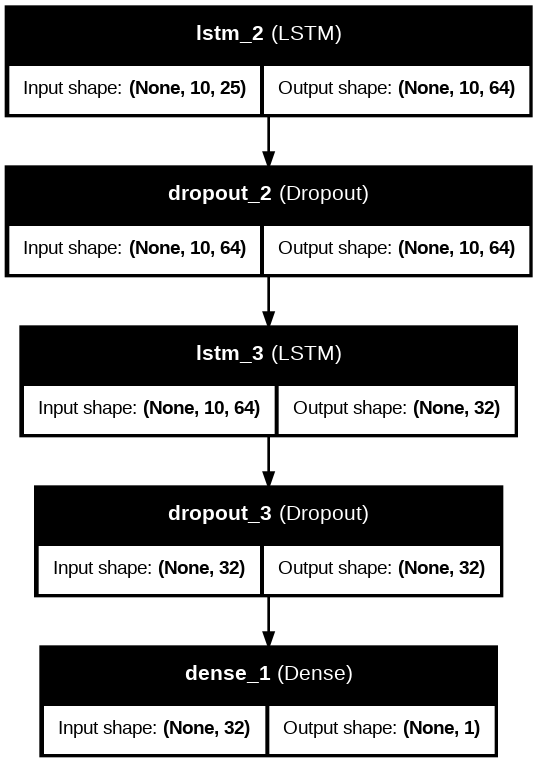

In [ ]:
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

# Visualize the model architecture
plot_model(
    model,
    to_file='lstm_model_architecture_graphviz.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)

# Display the image in a Jupyter Notebook or Python script
from IPython.display import Image
Image(filename='lstm_model_architecture_graphviz.png')